In [112]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import pymiediff as pmd
import torch
import numpy as np

In [113]:
core_radius = 12.0  # nm
shell_radius = 50.0  # nm
core_refractiveIndex = 2.0 + 0.1j
shell_refractiveIndex = 5.0 + 0.2j

optim_expression="q_sca"

In [114]:
starting_wavelength = 200  # nm
ending_wavelength = 600  # nm

N_pt_test = 250

wl = torch.linspace(starting_wavelength, ending_wavelength, N_pt_test, dtype=torch.double)

k0 = (
    2 * torch.pi / wl
)

In [115]:
def gaussian(x, mu, sig):
    return (
        1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
    )

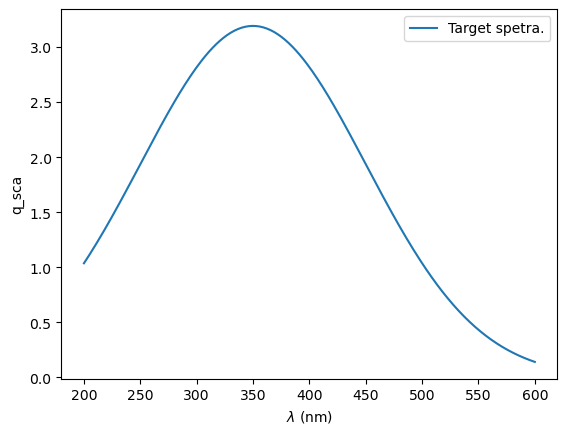

In [116]:
target = gaussian(wl.numpy(), 350.0, 100.0) * 800

plt.plot(wl, target, label = "Target spetra.")
plt.xlabel("$\lambda$ (nm)")
plt.ylabel(optim_expression)
plt.legend()
plt.show()

# target = torch.tensor(target)

In [117]:
# r_s, n_cRe, n_cIm, n_sRe, n_sIm

def objective_function(x):
    cross_section = pmd.farfield.cross_sections(
        k0=k0,
        r_c=12.0,
        eps_c=(x[1] + 1j*x[2]) ** 2,
        r_s=x[0],
        eps_s=(x[3] + 1j*x[4]) ** 2,
        eps_env=1,
        n_max=8,
    )[optim_expression]

    penalty_loss = 0.01 / x[1] + 0.01 / x[3]

    return np.mean(np.square((cross_section.detach().numpy() - target))) + penalty_loss

In [ ]:
import time

bnds = ((12.0, 1e4), (0.1, 20), (-20, 20), (0.1, 20), (-20, 20))


t0 = time.time()
result = minimize(
    objective_function,
    [50.0, 2.0, 0.1, 5.0, 0.2],
    method='L-BFGS-B',
    # bounds=bnds,
    # options={'maxiter':10}
    )
opti_parms = result.x  # Optimal solution
t1 = time.time()
print(t1 - t0)
print(opti_parms)

54.72338843345642
[69.71694274  1.91973818 -1.88978018  2.66273482  0.25674175]


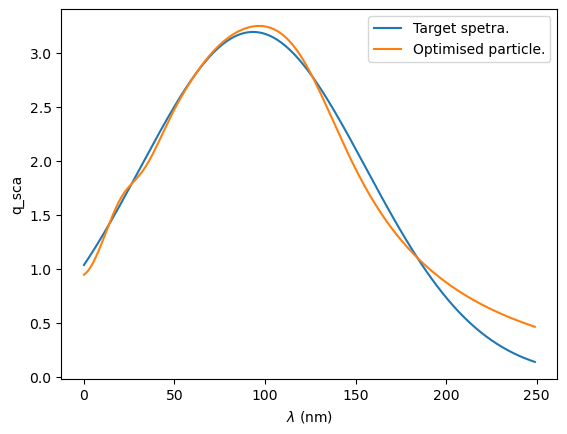

In [119]:
opti_spectra  = cross_section = pmd.farfield.cross_sections(
        k0=k0,
        r_c=12.0,
        eps_c=(opti_parms[1] + 1j*opti_parms[2]) ** 2,
        r_s=opti_parms[0],
        eps_s=(opti_parms[3] + 1j*opti_parms[4]) ** 2,
        eps_env=1,
        n_max=8,
    )[optim_expression]


plt.plot( target, label = "Target spetra.")
plt.plot( opti_spectra, label = "Optimised particle.")
plt.xlabel("$\lambda$ (nm)")
plt.ylabel(optim_expression)
plt.legend()
plt.show()